# PDF Fitting Methods Comparison for 10**Y_train

This notebook compares four different methods for fitting **10**Y_train** data:
1. **Two-Component Log-Normal** (6 parameters)
2. **Polynomial Degree 10** (11 parameters)
3. **Shifted Log-Normal** (4 parameters)
4. **Power-Shifted Log-Normal** (5 parameters)

The goal is to find the optimal parameterization method for use with MomentEmu PolyEmu framework.

## Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import lognorm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib available")
print(f"SciPy optimization available")
print(f"Sklearn metrics available")
print(f"PCA for parameter space analysis available")

Libraries imported successfully!
NumPy version: 2.1.3
Matplotlib available
SciPy optimization available
Sklearn metrics available
PCA for parameter space analysis available


## Load and Prepare Training Data

In [2]:
training_parameters = np.load('train_linear_params_0.npz')
training_features = np.load('train_linear_logpower_0.npz')
model_parameters = ['z_frb','eta','deta','Nstar','ciga','thco','Mc','mu','delta','gamma']
X_train = np.stack([training_parameters[key] for key in model_parameters], axis=1)
Y_train_log = training_features['features']
X_train[:,6] = np.log10(X_train[:,6])
Y_train = 10.0 ** Y_train_log

## Define Fitting Functions (for log Y)

In [3]:
def lognormal(x, mu, sigma, scale):
    with np.errstate(divide='ignore', invalid='ignore'):
        x = np.maximum(x, 1e-10)  # Avoid log(0)
        return - np.log(x) - 0.5 * ((np.log(x) - mu) / sigma)**2 + scale


def shifted_lognormal(x, mu, sigma, scale, shift):
    """
    Shifted log-normal PDF: log-normal applied to (x + shift), not normalized
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        x_shifted = np.maximum(x + shift, 1e-10)
        return - np.log(x_shifted) - 0.5 * ((np.log(x_shifted) - mu) / sigma)**2 + scale

def two_component_lognormal(x, mu1, sigma1, scale1, mu2, sigma2, scale2):
    """
    Two-component log-normal PDF (mixture of two log-normals, not normalized)
    """
    component1 = lognormal(x, mu1, sigma1, scale1)
    component2 = lognormal(x, mu2, sigma2, scale2)
    return np.log(np.exp(component1) + np.exp(component2))

def power_shifted_lognormal(x, mu, sigma, scale, shift, alpha):
    """
    Power-shifted log-normal PDF: (scale/(x+shift))^alpha * exp(-0.5*((log(x+shift)-mu)/sigma)^2), not normalized
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        x_shifted = np.maximum(x + shift, 1e-10)

        return - np.log(x_shifted) * alpha - 0.5 * ((np.log(x_shifted) - mu) / sigma)**2 + scale

def polynomial_fit_func(x, *coeffs):
    """
    Polynomial function of arbitrary degree
    """
    degree = len(coeffs) - 1
    return sum(c * x**i for i, c in enumerate(coeffs))

## Fitting Algorithm Implementations

In [8]:
def fit_lognormal(Y_train_log):
    """Fit simple log-normal model to each curve in Y_train_log"""
    results = []
    
    for i in range(len(Y_train_log)):
        # x_data is just the index positions (0, 1, 2, ..., len-1)
        x_data = np.arange(Y_train_log.shape[1])
        y_data = Y_train_log[i, :]
        
        # Initial guess
        p0 = [np.mean(np.log(x_data + 1e-10)), 1.0, np.mean(y_data)]
        
        try:
            popt, _ = curve_fit(lognormal, x_data, y_data, p0=p0, 
                              bounds=([-10, 0.1, -50], [10, 10, 50]),
                              maxfev=5000)
            
            # Calculate R² and MSE
            y_pred = lognormal(x_data, *popt)
            r2 = r2_score(y_data, y_pred)
            mse = mean_squared_error(y_data, y_pred)
            
            results.append({
                'params': popt,
                'r2': r2,
                'mse': mse,
                'method': 'lognormal'
            })
        except:
            results.append({
                'params': None,
                'r2': -np.inf,
                'mse': np.inf,
                'method': 'lognormal'
            })
    
    return results

def fit_shifted_lognormal(Y_train_log):
    """Fit shifted log-normal model to each curve in Y_train_log"""
    results = []
    
    for i in range(len(Y_train_log)):
        # x_data is just the index positions (0, 1, 2, ..., len-1)
        x_data = np.arange(Y_train_log.shape[1])
        y_data = Y_train_log[i, :]
        
        # Initial guess
        p0 = [np.mean(np.log(x_data + 1e-10)), 1.0, np.mean(y_data), 0.1]
        
        try:
            popt, _ = curve_fit(shifted_lognormal, x_data, y_data, p0=p0,
                              bounds=([-10, 0.1, -50, -100], [10, 10, 50, 1000]),
                              maxfev=5000)
            
            # Calculate R² and MSE
            y_pred = shifted_lognormal(x_data, *popt)
            r2 = r2_score(y_data, y_pred)
            mse = mean_squared_error(y_data, y_pred)
            
            results.append({
                'params': popt,
                'r2': r2,
                'mse': mse,
                'method': 'shifted_lognormal'
            })
        except:
            results.append({
                'params': None,
                'r2': -np.inf,
                'mse': np.inf,
                'method': 'shifted_lognormal'
            })
    
    return results

In [9]:
def fit_two_component_lognormal(Y_train_log):
    """Fit two-component log-normal model to each curve in Y_train_log"""
    results = []
    
    for i in range(len(Y_train_log)):
        # x_data is just the index positions (0, 1, 2, ..., len-1)
        x_data = np.arange(Y_train_log.shape[1])
        y_data = Y_train_log[i, :]
        
        # Initial guess for 6 parameters
        p0 = [np.mean(np.log(x_data + 1e-10)), 1.0, np.mean(y_data),
              np.mean(np.log(x_data + 1e-10)) + 1, 1.0, np.mean(y_data)]
        
        try:
            popt, _ = curve_fit(two_component_lognormal, x_data, y_data, p0=p0,
                              bounds=([-10, 0.1, -50, -10, 0.1, -50],
                                    [10, 10, 50, 10, 10, 50]),
                              maxfev=10000)
            
            # Calculate R² and MSE
            y_pred = two_component_lognormal(x_data, *popt)
            r2 = r2_score(y_data, y_pred)
            mse = mean_squared_error(y_data, y_pred)
            
            results.append({
                'params': popt,
                'r2': r2,
                'mse': mse,
                'method': 'two_component_lognormal'
            })
        except:
            results.append({
                'params': None,
                'r2': -np.inf,
                'mse': np.inf,
                'method': 'two_component_lognormal'
            })
    
    return results

def fit_power_shifted_lognormal(Y_train_log):
    """Fit power-shifted log-normal model to each curve in Y_train_log"""
    results = []
    
    for i in range(len(Y_train_log)):
        # x_data is just the index positions (0, 1, 2, ..., len-1)
        x_data = np.arange(Y_train_log.shape[1])
        y_data = Y_train_log[i, :]
        
        # Initial guess for 5 parameters: mu, sigma, scale, shift, alpha
        p0 = [np.mean(np.log(x_data + 1e-10)), 1.0, np.mean(y_data), 0.1, 1.0]
        
        try:
            popt, _ = curve_fit(power_shifted_lognormal, x_data, y_data, p0=p0,
                              bounds=([-10, 0.1, -50, -100, 0.1],
                                    [10, 10, 50, 1000, 5]),
                              maxfev=10000)
            
            # Calculate R² and MSE
            y_pred = power_shifted_lognormal(x_data, *popt)
            r2 = r2_score(y_data, y_pred)
            mse = mean_squared_error(y_data, y_pred)
            
            results.append({
                'params': popt,
                'r2': r2,
                'mse': mse,
                'method': 'power_shifted_lognormal'
            })
        except:
            results.append({
                'params': None,
                'r2': -np.inf,
                'mse': np.inf,
                'method': 'power_shifted_lognormal'
            })
    
    return results

In [10]:
def fit_polynomial_deg10(Y_train_log):
    """Fit polynomial degree 10 model to each curve in Y_train_log"""
    results = []
    
    for i in range(len(Y_train_log)):
        # x_data is just the index positions (0, 1, 2, ..., len-1)
        x_data = np.arange(Y_train_log.shape[1])
        y_data = Y_train_log[i, :]
        
        # Initial guess for 11 parameters (degree 10 polynomial)
        p0 = [0.0] * 11
        p0[0] = np.mean(y_data)  # Constant term
        
        try:
            popt, _ = curve_fit(polynomial_fit_func, x_data, y_data, p0=p0,
                              maxfev=10000)
            
            # Calculate R² and MSE
            y_pred = polynomial_fit_func(x_data, *popt)
            r2 = r2_score(y_data, y_pred)
            mse = mean_squared_error(y_data, y_pred)
            
            results.append({
                'params': popt,
                'r2': r2,
                'mse': mse,
                'method': 'polynomial_deg10'
            })
        except:
            results.append({
                'params': None,
                'r2': -np.inf,
                'mse': np.inf,
                'method': 'polynomial_deg10'
            })
    
    return results

print("All fitting functions defined successfully!")
print("Available methods:")
print("1. fit_lognormal (3 parameters)")
print("2. fit_shifted_lognormal (4 parameters)")
print("3. fit_two_component_lognormal (6 parameters)")
print("4. fit_power_shifted_lognormal (5 parameters)")
print("5. fit_polynomial_deg10 (11 parameters)")

All fitting functions defined successfully!
Available methods:
1. fit_lognormal (3 parameters)
2. fit_shifted_lognormal (4 parameters)
3. fit_two_component_lognormal (6 parameters)
4. fit_power_shifted_lognormal (5 parameters)
5. fit_polynomial_deg10 (11 parameters)


## Run All Fitting Methods and Compare Performance

In [11]:
# Run all fitting methods
print("Starting fitting comparison...")
print(f"Data shape: Y_train_log = {Y_train_log.shape}")
print(f"Fitting each of {Y_train_log.shape[0]} curves with {Y_train_log.shape[1]} points each")
print()

# Fit with all methods
print("1. Fitting with log-normal...")
results_lognormal = fit_lognormal(Y_train_log)

print("2. Fitting with shifted log-normal...")
results_shifted = fit_shifted_lognormal(Y_train_log)

print("3. Fitting with two-component log-normal...")
results_two_comp = fit_two_component_lognormal(Y_train_log)

print("4. Fitting with power-shifted log-normal...")
results_power_shifted = fit_power_shifted_lognormal(Y_train_log)

print("5. Fitting with polynomial degree 10...")
results_polynomial = fit_polynomial_deg10(Y_train_log)

print("\nAll fitting methods completed!")

# Combine results
all_results = {
    'lognormal': results_lognormal,
    'shifted_lognormal': results_shifted,
    'two_component_lognormal': results_two_comp,
    'power_shifted_lognormal': results_power_shifted,
    'polynomial_deg10': results_polynomial
}

Starting fitting comparison...
Data shape: Y_train_log = (79948, 1000)
Fitting each of 79948 curves with 1000 points each

1. Fitting with log-normal...
2. Fitting with shifted log-normal...
3. Fitting with two-component log-normal...
4. Fitting with power-shifted log-normal...
5. Fitting with polynomial degree 10...

All fitting methods completed!


## Performance Analysis and Statistics

In [12]:
# Calculate performance statistics
import pandas as pd

def analyze_performance(all_results):
    """Analyze performance across all methods"""
    
    performance_summary = {}
    
    for method_name, results in all_results.items():
        # Extract R² and MSE values
        r2_values = [r['r2'] for r in results if r['r2'] != -np.inf]
        mse_values = [r['mse'] for r in results if r['mse'] != np.inf]
        
        # Count successful fits
        successful_fits = len([r for r in results if r['params'] is not None])
        total_samples = len(results)
        
        # Calculate statistics
        performance_summary[method_name] = {
            'success_rate': successful_fits / total_samples * 100,
            'mean_r2': np.mean(r2_values) if r2_values else 0,
            'std_r2': np.std(r2_values) if r2_values else 0,
            'median_r2': np.median(r2_values) if r2_values else 0,
            'mean_mse': np.mean(mse_values) if mse_values else np.inf,
            'std_mse': np.std(mse_values) if mse_values else 0,
            'median_mse': np.median(mse_values) if mse_values else np.inf,
            'num_parameters': {
                'lognormal': 3,
                'shifted_lognormal': 4,
                'two_component_lognormal': 6,
                'power_shifted_lognormal': 5,
                'polynomial_deg10': 11
            }[method_name]
        }
    
    return performance_summary

# Analyze performance
perf_summary = analyze_performance(all_results)

# Create DataFrame for easy viewing
df_performance = pd.DataFrame(perf_summary).T
print("PERFORMANCE SUMMARY")
print("=" * 50)
print(df_performance.round(4))

print("\n\nDETAILED ANALYSIS")
print("=" * 50)
for method, stats in perf_summary.items():
    print(f"\n{method.upper()}:")
    print(f"  Parameters: {stats['num_parameters']}")
    print(f"  Success Rate: {stats['success_rate']:.1f}%")
    print(f"  Mean R²: {stats['mean_r2']:.4f} ± {stats['std_r2']:.4f}")
    print(f"  Median R²: {stats['median_r2']:.4f}")
    print(f"  Mean MSE: {stats['mean_mse']:.4f} ± {stats['std_mse']:.4f}")
    print(f"  Median MSE: {stats['median_mse']:.4f}")

PERFORMANCE SUMMARY
                         success_rate       mean_r2        std_r2  \
lognormal                     99.7098 -2.279000e-01  7.619000e-01   
shifted_lognormal             99.7098  9.145000e-01  4.650000e-02   
two_component_lognormal       99.7098  9.504000e-01  4.150000e-02   
power_shifted_lognormal       99.7098  9.149000e-01  4.650000e-02   
polynomial_deg10             100.0000 -1.452215e+09  1.955083e+09   

                            median_r2      mean_mse       std_mse  \
lognormal               -1.696000e-01  2.205000e+00  3.410000e+00   
shifted_lognormal        9.115000e-01  3.795000e-01  3.311400e+00   
two_component_lognormal  9.443000e-01  8.930000e-02  4.924000e-01   
power_shifted_lognormal  9.119000e-01  2.517000e-01  1.735100e+00   
polynomial_deg10        -8.362588e+08  3.514089e+09  6.364467e+09   

                           median_mse  num_parameters  
lognormal                1.763800e+00             3.0  
shifted_lognormal        1.345000e-01 

## Example Fits for Best Performing Samples

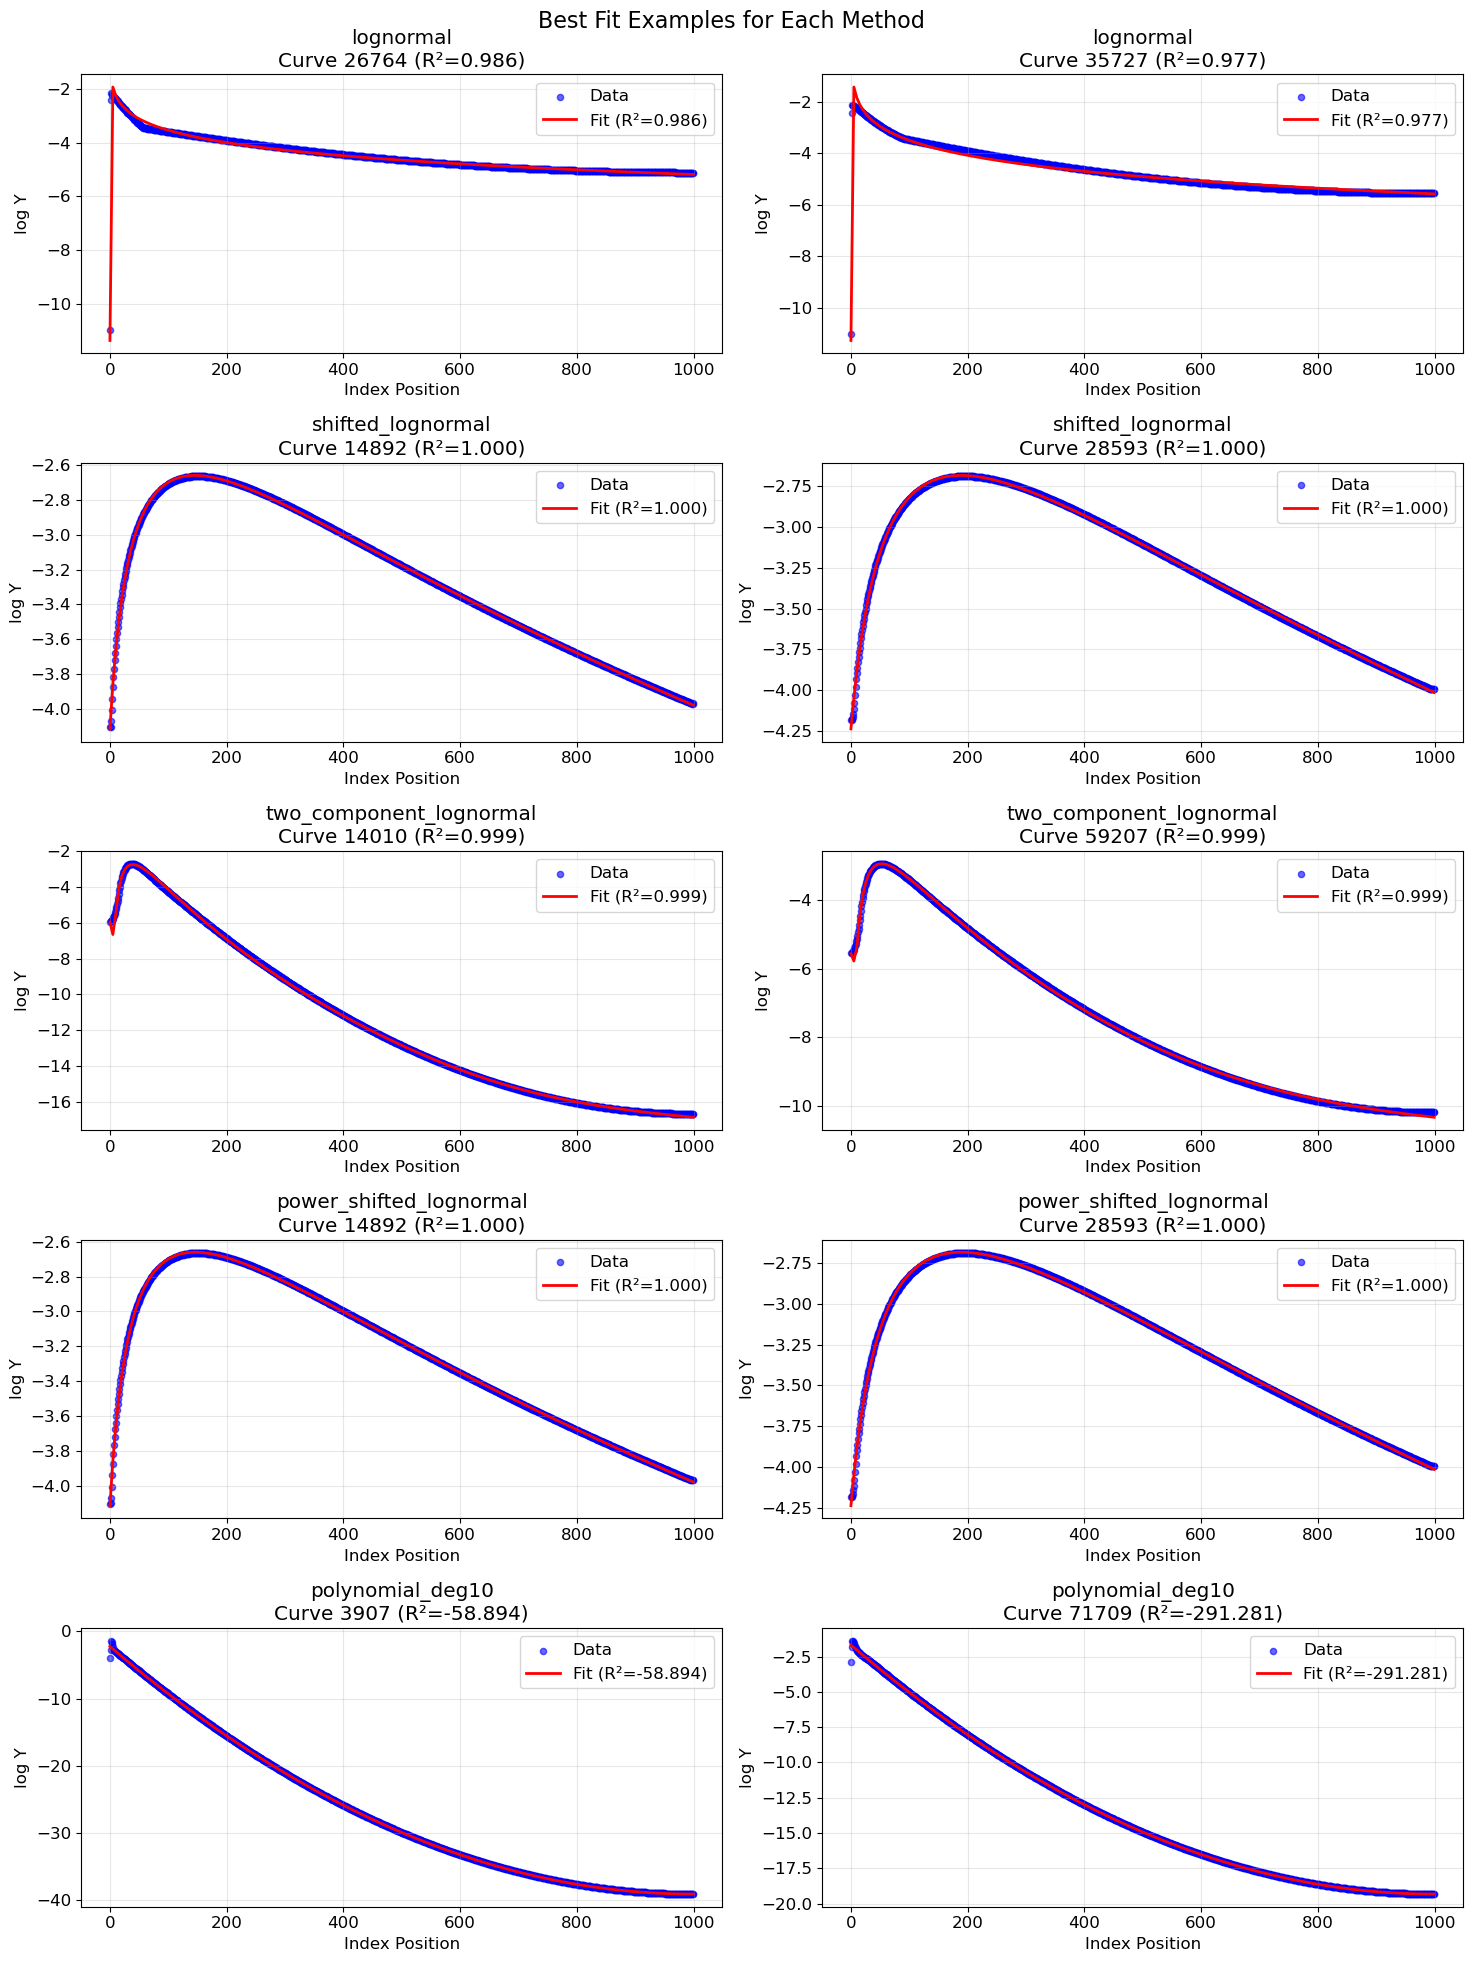

In [14]:
# Show example fits for samples with best R² scores
def plot_best_fits(all_results, Y_train_log, num_examples=3):
    """Plot best fitting examples for each method"""
    
    fig, axes = plt.subplots(len(methods), num_examples, figsize=(15, 20))
    fig.suptitle('Best Fit Examples for Each Method', fontsize=16)
    
    fitting_functions = {
        'lognormal': lognormal,
        'shifted_lognormal': shifted_lognormal,
        'two_component_lognormal': two_component_lognormal,
        'power_shifted_lognormal': power_shifted_lognormal,
        'polynomial_deg10': polynomial_fit_func
    }
    
    for i, method in enumerate(methods):
        # Get best fits based on R² score
        results = all_results[method]
        valid_results = [(j, r) for j, r in enumerate(results) if r['params'] is not None]
        valid_results.sort(key=lambda x: x[1]['r2'], reverse=True)
        
        for j in range(min(num_examples, len(valid_results))):
            ax = axes[i, j] if len(methods) > 1 else axes[j]
            
            sample_idx, result = valid_results[j]
            # x_data is just index positions for this curve
            x_data = np.arange(Y_train_log.shape[1])
            y_data = Y_train_log[sample_idx, :]
            
            # Plot original data
            ax.scatter(x_data, y_data, alpha=0.6, s=20, label='Data', color='blue')
            
            # Plot fitted curve
            if result['params'] is not None:
                x_smooth = np.linspace(0, Y_train_log.shape[1]-1, 200)
                y_fit = fitting_functions[method](x_smooth, *result['params'])
                ax.plot(x_smooth, y_fit, 'r-', linewidth=2, 
                       label=f'Fit (R²={result["r2"]:.3f})')
            
            ax.set_title(f'{method}\nCurve {sample_idx} (R²={result["r2"]:.3f})')
            ax.set_xlabel('Index Position')
            ax.set_ylabel('log Y')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot best fits
plot_best_fits(all_results, Y_train_log, num_examples=2)

## Summary and Recommendations

In [15]:
# Final analysis and recommendations
print("FINAL ANALYSIS AND RECOMMENDATIONS")
print("=" * 50)

# Rank methods by different criteria
methods_list = list(perf_summary.keys())

# By mean R²
by_r2 = sorted(methods_list, key=lambda x: perf_summary[x]['mean_r2'], reverse=True)
print(f"\nRANKING BY MEAN R² SCORE:")
for i, method in enumerate(by_r2):
    print(f"{i+1}. {method}: {perf_summary[method]['mean_r2']:.4f}")

# By success rate
by_success = sorted(methods_list, key=lambda x: perf_summary[x]['success_rate'], reverse=True)
print(f"\nRANKING BY SUCCESS RATE:")
for i, method in enumerate(by_success):
    print(f"{i+1}. {method}: {perf_summary[method]['success_rate']:.1f}%")

# By MSE (lower is better)
by_mse = sorted(methods_list, key=lambda x: perf_summary[x]['mean_mse'])
print(f"\nRANKING BY MEAN MSE (lower is better):")
for i, method in enumerate(by_mse):
    print(f"{i+1}. {method}: {perf_summary[method]['mean_mse']:.4f}")

# Parameter efficiency (R² per parameter)
efficiency_scores = {}
for method in methods_list:
    if perf_summary[method]['mean_r2'] > 0:
        efficiency_scores[method] = perf_summary[method]['mean_r2'] / perf_summary[method]['num_parameters']
    else:
        efficiency_scores[method] = 0

by_efficiency = sorted(methods_list, key=lambda x: efficiency_scores[x], reverse=True)
print(f"\nRANKING BY PARAMETER EFFICIENCY (R²/num_params):")
for i, method in enumerate(by_efficiency):
    print(f"{i+1}. {method}: {efficiency_scores[method]:.4f} ({perf_summary[method]['mean_r2']:.4f}/{perf_summary[method]['num_parameters']})")

print(f"\n\nRECOMMENDATIONS:")
print("-" * 30)

# Find best overall method
best_r2_method = by_r2[0]
best_success_method = by_success[0]
best_efficiency_method = by_efficiency[0]

print(f"🏆 BEST OVERALL PERFORMANCE: {best_r2_method}")
print(f"   - Highest mean R² score: {perf_summary[best_r2_method]['mean_r2']:.4f}")
print(f"   - Success rate: {perf_summary[best_r2_method]['success_rate']:.1f}%")
print(f"   - Parameters: {perf_summary[best_r2_method]['num_parameters']}")

print(f"\n🎯 MOST RELIABLE: {best_success_method}")
print(f"   - Success rate: {perf_summary[best_success_method]['success_rate']:.1f}%")
print(f"   - Mean R² score: {perf_summary[best_success_method]['mean_r2']:.4f}")

print(f"\n⚡ MOST EFFICIENT: {best_efficiency_method}")
print(f"   - Parameter efficiency: {efficiency_scores[best_efficiency_method]:.4f}")
print(f"   - Only {perf_summary[best_efficiency_method]['num_parameters']} parameters")

print(f"\n💡 CONCLUSIONS:")
print(f"   - For MomentEmu PolyEmu framework, consider using {best_r2_method}")
print(f"   - If robustness is critical, {best_success_method} might be better")
print(f"   - For computational efficiency, {best_efficiency_method} offers good performance with fewer parameters")

# Check if power_shifted_lognormal performed well
if 'power_shifted_lognormal' in perf_summary:
    psl_rank_r2 = by_r2.index('power_shifted_lognormal') + 1
    psl_performance = perf_summary['power_shifted_lognormal']
    print(f"\n🔬 POWER-SHIFTED LOG-NORMAL ANALYSIS:")
    print(f"   - Ranked #{psl_rank_r2} in R² performance")
    print(f"   - Mean R²: {psl_performance['mean_r2']:.4f}")
    print(f"   - Success rate: {psl_performance['success_rate']:.1f}%")
    print(f"   - This method shows {'promising' if psl_rank_r2 <= 2 else 'moderate' if psl_rank_r2 <= 3 else 'limited'} potential for your data")

FINAL ANALYSIS AND RECOMMENDATIONS

RANKING BY MEAN R² SCORE:
1. two_component_lognormal: 0.9504
2. power_shifted_lognormal: 0.9149
3. shifted_lognormal: 0.9145
4. lognormal: -0.2279
5. polynomial_deg10: -1452214596.0879

RANKING BY SUCCESS RATE:
1. polynomial_deg10: 100.0%
2. lognormal: 99.7%
3. shifted_lognormal: 99.7%
4. two_component_lognormal: 99.7%
5. power_shifted_lognormal: 99.7%

RANKING BY MEAN MSE (lower is better):
1. two_component_lognormal: 0.0893
2. power_shifted_lognormal: 0.2517
3. shifted_lognormal: 0.3795
4. lognormal: 2.2050
5. polynomial_deg10: 3514089446.9129

RANKING BY PARAMETER EFFICIENCY (R²/num_params):
1. shifted_lognormal: 0.2286 (0.9145/4)
2. power_shifted_lognormal: 0.1830 (0.9149/5)
3. two_component_lognormal: 0.1584 (0.9504/6)
4. lognormal: 0.0000 (-0.2279/3)
5. polynomial_deg10: 0.0000 (-1452214596.0879/11)


RECOMMENDATIONS:
------------------------------
🏆 BEST OVERALL PERFORMANCE: two_component_lognormal
   - Highest mean R² score: 0.9504
   - Succe

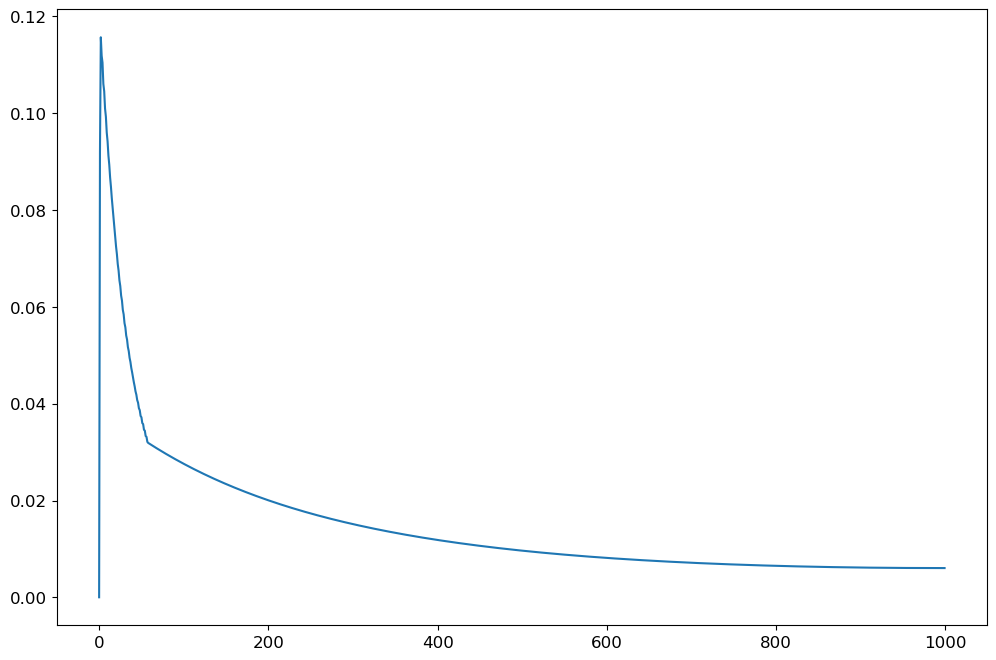

In [19]:
plt.plot(np.exp(Y_train_log[26764]))

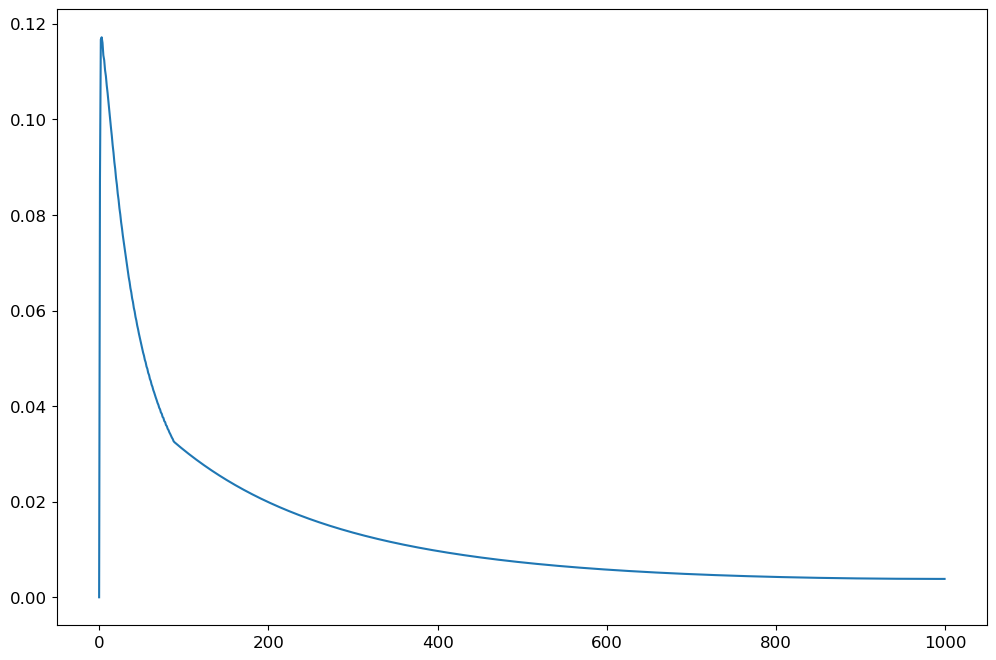

In [20]:
plt.plot(np.exp(Y_train_log[35727]))

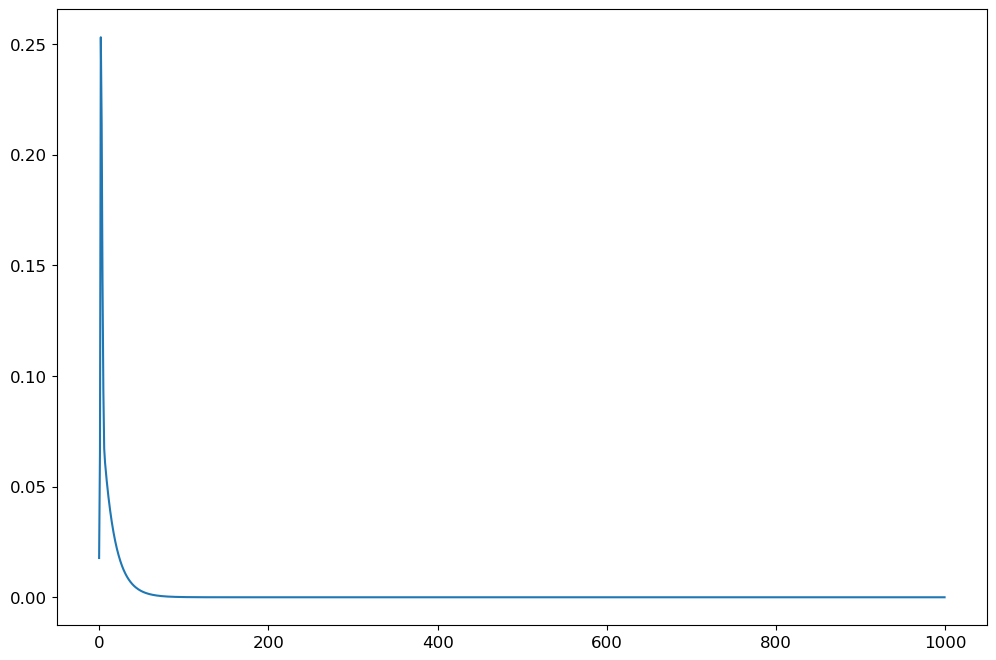

In [21]:
plt.plot(np.exp(Y_train_log[3907]))

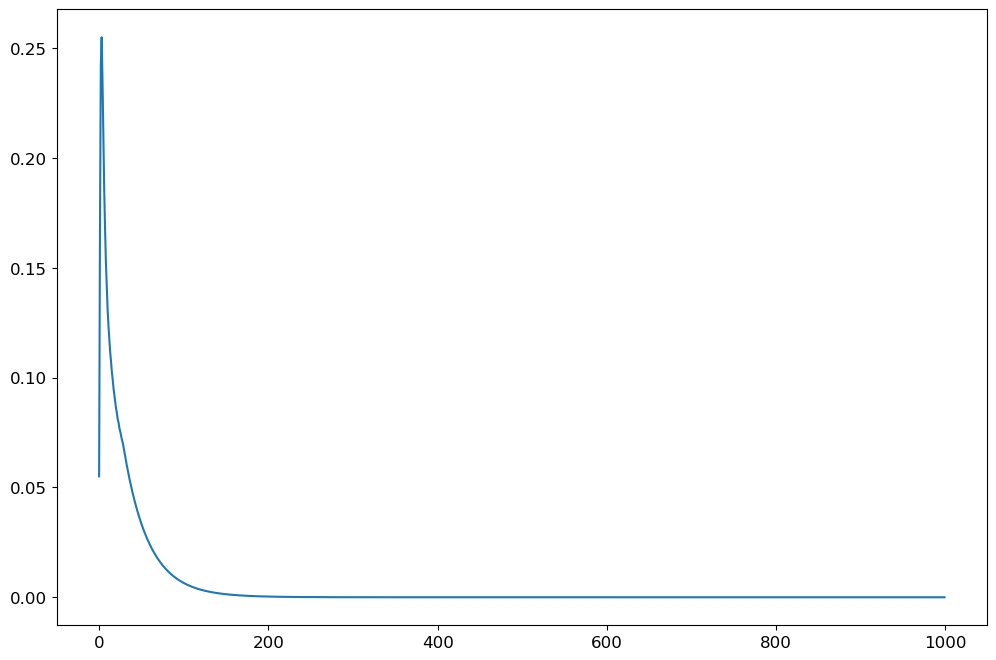

In [22]:
plt.plot(np.exp(Y_train_log[71709]))